### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 27 апреля 2020, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 27 апреля, -4 балла после 08:30 4 мая, -6 баллов после 08:30 11 мая, -8 баллов после 08:30 18 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0220, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from  scipy.stats import mode
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [2]:
class MyDecisionTreeClassifier:
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=None, sufficient_share=1.0, criterion='gini', max_features=None):
        self.tree = dict()
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.sufficient_share = sufficient_share
        self.num_class = -1
        self.feature_importances_ = []
        if criterion == 'gini':
            self.G_function = self.__gini
        elif criterion == 'entropy':
            self.G_function = self.__entropy
        elif criterion == 'misclass':
            self.G_function = self.__misclass

    def __gini(self, l_c, l_s, r_c, r_s):
        l_s = l_s.astype('float')
        r_s = r_s.astype('float')
        return  1 - np.sum((l_c ** 2) / (l_s * (l_s + r_s)) + (r_c ** 2) / (r_s * (l_s + r_s)), axis=1)
    
    def __entropy(self, l_c, l_s, r_c, r_s):
        return -np.sum((l_c / l_s).log2() * l_c / (l_s + r_s) + (r_c / r_s).log2() * r_c / (l_s + r_s), axis=1)

    def __misclass(self, l_c, l_s, r_c, r_s):
        return 1 - np.max(l_c / (l_s + r_s), axis=1) - np.max(r_c / (l_s + r_s), axis=1)
    
    def __sort_samples(self, x, y):
        sorted_idx = x.argsort()
        return x[sorted_idx], y[sorted_idx]

    def __div_samples(self, x, y, feature_id, threshold):
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        xsort, ysort = self.__sort_samples(x, y)
        classnum = self.num_class
        tocut = np.int(self.min_samples_split / 2 - 1)
        if tocut == 0:
            ysplit = ysort
        else:
            ysplit = ysort[tocut:-tocut]
        newind = np.where(ysplit[:-1] != ysplit[1:])[0] + (tocut + 1)
        if len(newind) == 0:
            return np.inf, None
        equal = newind - np.append(np.array([tocut]), newind[:-1])
        changemat = np.zeros((newind.shape[0], classnum))
        changemat[np.arange(newind.shape[0]), ysort[newind - 1]] = 1
        classnummat = changemat * equal.reshape(-1, 1)
        classnummat[0] = classnummat[0] + np.bincount(ysort[:tocut], minlength=classnum)
        lclassnum = np.cumsum(classnummat, axis=0)
        rclassnum = np.bincount(ysort, minlength=classnum) - lclassnum
        lsizes = newind.reshape(lclassnum.shape[0], 1)
        rsizes = ysort.shape[0] - lsizes
        imp = self.G_function(lclassnum, lsizes, rclassnum, rsizes)
        ind = np.argmin(imp)
        return imp[ind], (xsort[lsizes[ind][0]-1] + xsort[lsizes[ind][0]]) / 2.0

    def __fit_node(self, x, y, node_id, depth):
        if depth == self.max_depth or self.min_samples_split >= x.shape[0] or len(np.unique(y)) == 1:
            self.tree[node_id] = (self.__class__.LEAF_TYPE,
                                  np.bincount(y).argmax(), np.bincount(y) / y.size)
            return
        threshold = np.array([self.__find_threshold(x[:, i], y) for i in range(x.shape[1])])
        feature = threshold[:, 0].argmin()
        best_threshold = threshold[feature, 1]
        self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature, best_threshold)

        X_l, X_r, y_l, y_r = self.__div_samples(x, y, feature, best_threshold)
        if X_l.shape[0] == 0 or X_r.shape[0] == 0:
            self.tree[node_id] = (self.__class__.LEAF_TYPE, np.bincount(y).argmax(), np.bincount(y).astype(float) / y.size)
            return

        self.__fit_node(X_l, y_l, 2 * node_id + 1, depth + 1)
        self.__fit_node(X_r, y_r, 2 * node_id + 2, depth + 1)
    
    def fit(self, x, y):
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                self.feature_importances_.append(feature_id)
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        return np.array([self.__predict_class(x, 0) for x in X])

    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance():
        pass

In [3]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [4]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [5]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [6]:
accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

0.8333333333333334

In [7]:
accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test)

0.8333333333333334

## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [8]:
%time clf.fit(X_train, y_train)

CPU times: user 1.9 ms, sys: 1.05 ms, total: 2.95 ms
Wall time: 1.96 ms


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [9]:
%time my_clf.fit(X_train, y_train)

CPU times: user 18.3 ms, sys: 1.23 ms, total: 19.5 ms
Wall time: 18.2 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [10]:
df = pd.read_csv('Speed Dating Data.csv', encoding='latin1')

Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

In [11]:

df = df.iloc[:, :97]

df = df.drop(['id'], axis=1)
df = df.drop(['idg'], axis=1)
df = df.drop(['condtn'], axis=1)

df = df.drop(['round'], axis=1)

df = df.drop(['position', 'positin1'], axis=1)

df = df.drop(['order'], axis=1)

df = df.drop(['partner'], axis=1)


df = df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1)

df = df.dropna(subset=['age'])

df.loc[:, 'field_cd'] = df.loc[:, 'field_cd'].fillna(19)

df = df.drop(['field'], axis=1)

df = df.drop(['undergra'], axis=1)

df = df.dropna(subset=['imprelig', 'imprace'])

df = df.drop(['from', 'zipcode'], axis=1)

df = df.drop(['income'], axis=1)
df = df.dropna(subset=['date'])
y = df['match']
df = df.drop(['match'], axis=1)

X = df.select_dtypes(exclude=['object']).fillna(0)

In [12]:
X.shape

(8249, 62)

In [13]:
y.shape

(8249,)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()

In [15]:
my_clf_gini = MyDecisionTreeClassifier(min_samples_split=2, max_depth=6, criterion='gini')
my_clf_gini.fit(X_train, y_train)
accuracy_score(y_pred=my_clf_gini.predict(X_val), y_true = y_val)

0.8254545454545454

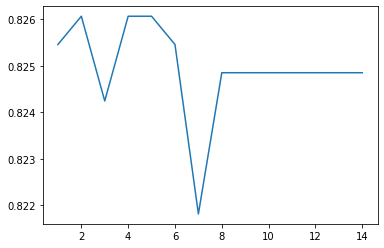

In [16]:
scores = []
depths = range(1, 15)
for max_depth in depths:
    my_clf = MyDecisionTreeClassifier(min_samples_split=3, max_depth=max_depth, criterion='gini')
    my_clf.fit(X_train, y_train)
    scores.append(accuracy_score(y_pred=my_clf.predict(X_val), y_true=y_val))
plt.plot(depths, scores)

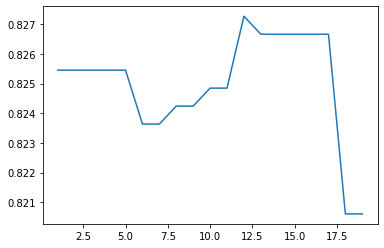

In [17]:
scores = []
samples_split = range(1, 20)
for min_samples_split in samples_split:
    my_clf = MyDecisionTreeClassifier(min_samples_split=min_samples_split, max_depth=6, criterion='gini')
    my_clf.fit(X_train, y_train)
    scores.append( accuracy_score(y_pred=my_clf.predict(X_val), y_true=y_val) )
plt.plot(samples_split, scores)

In [18]:
my_clf = MyDecisionTreeClassifier(min_samples_split=11, max_depth=2, criterion='gini')
my_clf.fit(X_train, y_train)
accuracy_score(y_pred=my_clf.predict(X_val), y_true=y_val)

0.826060606060606

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ



Все ничего, не хватило времени на качественное тестирование модели.